In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def getsoup(url):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36 Edg/96.0.1054.43'
            }
    response = requests.get(url,headers=header)
    soup = BeautifulSoup(response.text,"html.parser")
    return response, soup

<h1>愛料理 

In [7]:
food = input('輸入食物: ')
url_icook = f"https://icook.tw/search/{food}"
response_icook, soup_icook = getsoup(url_icook)

data_icook = {'Name':[],'Materials':[],'Time':[],'Like':[]}
flag = True
pages = 1
#取得各頁
while flag:
    div_icook = soup_icook.find_all(class_="browse-recipe-item")
    for i in range(len(div_icook)):
        name = div_icook[i].find('h2').text.strip()
        try:
            material = div_icook[i].find('p').text.strip()
            material = re.sub(r'食材：', '', material).split('、')
        except: 
            material = 'No Offer'
        # 處理網站內meta標籤
        metas = div_icook[i].find_all('li', class_="browse-recipe-meta-item")
        for meta in metas:
            meta = meta.text.strip()
            if '分' in meta:
                time = re.sub(r'[分, ]','',meta)
            elif '讚' in meta:
                like = re.sub(r'[讚, ]','',meta)
                like = re.sub(r'[萬]','0000',like)
            else: 
                break
        # 存至data
        data_icook['Name'].append(name), data_icook['Materials'].append(material)
        data_icook['Time'].append(time), data_icook['Like'].append(like)
    #下一業
    try:
        pages += 1
        page_flag = eval(soup_icook.find_all('a', class_="pagination-tab-link--number")[-1].text)-1
        if pages>page_flag:
            flag = False
        else:    
            url_icook = f"https://icook.tw/search/{food}/?page={pages}"
            print(url_icook)
            response_icook, soup_icook = getsoup(url_icook)
    except:
        print('Error1')
        flag = False
        
#取得最後一頁
url_icook = f"https://icook.tw/search/{food}/?page={pages}"
print(url_icook)
response_icook, soup_icook = getsoup(url_icook)
div_icook = soup_icook.find_all(class_="browse-recipe-item")
for i in range(len(div_icook)):
    name = div_icook[i].find('h2').text.strip()
    material = div_icook[i].find('p').text.strip()
    material = re.sub(r'食材：', '', material).split('、')
    metas = div_icook[i].find_all('li', class_="browse-recipe-meta-item")
    for meta in metas:
        meta = meta.text.strip()
        if '分' in meta:
            time = re.sub(r'[分,]','',meta)
        elif '讚' in meta:
            like = re.sub(r'[讚,]','',meta)
        else:
            break
    data_icook['Name'].append(name), data_icook['Materials'].append(material)
    data_icook['Time'].append(time), data_icook['Like'].append(like)
    
# DataFrame
Icook = pd.DataFrame.from_dict(data_icook)
print('Finish')


輸入食物: 義大利麵
https://icook.tw/search/義大利麵/?page=2
https://icook.tw/search/義大利麵/?page=3
https://icook.tw/search/義大利麵/?page=4
https://icook.tw/search/義大利麵/?page=5
https://icook.tw/search/義大利麵/?page=6
https://icook.tw/search/義大利麵/?page=7
https://icook.tw/search/義大利麵/?page=8
https://icook.tw/search/義大利麵/?page=9
https://icook.tw/search/義大利麵/?page=10
https://icook.tw/search/義大利麵/?page=11
https://icook.tw/search/義大利麵/?page=12
https://icook.tw/search/義大利麵/?page=13
https://icook.tw/search/義大利麵/?page=14
https://icook.tw/search/義大利麵/?page=15
https://icook.tw/search/義大利麵/?page=16
https://icook.tw/search/義大利麵/?page=17
https://icook.tw/search/義大利麵/?page=18
https://icook.tw/search/義大利麵/?page=19
https://icook.tw/search/義大利麵/?page=20
https://icook.tw/search/義大利麵/?page=21
https://icook.tw/search/義大利麵/?page=22
https://icook.tw/search/義大利麵/?page=23
https://icook.tw/search/義大利麵/?page=24
https://icook.tw/search/義大利麵/?page=25
https://icook.tw/search/義大利麵/?page=26
https://icook.tw/search/義大利麵/?page=27
https://i

https://icook.tw/search/義大利麵/?page=215
https://icook.tw/search/義大利麵/?page=216
https://icook.tw/search/義大利麵/?page=217
https://icook.tw/search/義大利麵/?page=218
https://icook.tw/search/義大利麵/?page=219
https://icook.tw/search/義大利麵/?page=220
https://icook.tw/search/義大利麵/?page=221
https://icook.tw/search/義大利麵/?page=222
https://icook.tw/search/義大利麵/?page=223
https://icook.tw/search/義大利麵/?page=224
https://icook.tw/search/義大利麵/?page=225
https://icook.tw/search/義大利麵/?page=226
https://icook.tw/search/義大利麵/?page=227
https://icook.tw/search/義大利麵/?page=228
https://icook.tw/search/義大利麵/?page=229
https://icook.tw/search/義大利麵/?page=230
https://icook.tw/search/義大利麵/?page=231
https://icook.tw/search/義大利麵/?page=232
https://icook.tw/search/義大利麵/?page=233
https://icook.tw/search/義大利麵/?page=234
https://icook.tw/search/義大利麵/?page=235
https://icook.tw/search/義大利麵/?page=236
https://icook.tw/search/義大利麵/?page=237
https://icook.tw/search/義大利麵/?page=238
https://icook.tw/search/義大利麵/?page=239
https://icook.tw/search/義

## 圖表設定

In [8]:
#str轉int
Icook['Like'], Icook['Time'] = Icook['Like'].astype(int), Icook['Time'].astype(int)
#排序
Icook = Icook.sort_values(by=['Like'], ascending=False,)
#Style
#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print(f'共{len(Icook)}項')

Icook.to_csv(f'{food}食譜.csv',encoding='utf-8-sig')
(Icook.style
 .set_caption(f'{food}大全')
 .bar('Time', vmin=0)
 .background_gradient('Blues', subset='Like')
)

共4973項


## 材料種類

In [9]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Material_Types = to_1D(Icook['Materials']).value_counts()
Material_Types

義大利麵               2099
洋蔥                 1933
鹽                  1711
橄欖油                1291
蒜頭                 1238
                   ... 
Tagliatelle義大利麵       1
粟粉/生粉                 1
義大利麵.                 1
熱水(1)                 1
越南春捲皮                 1
Length: 9227, dtype: int64

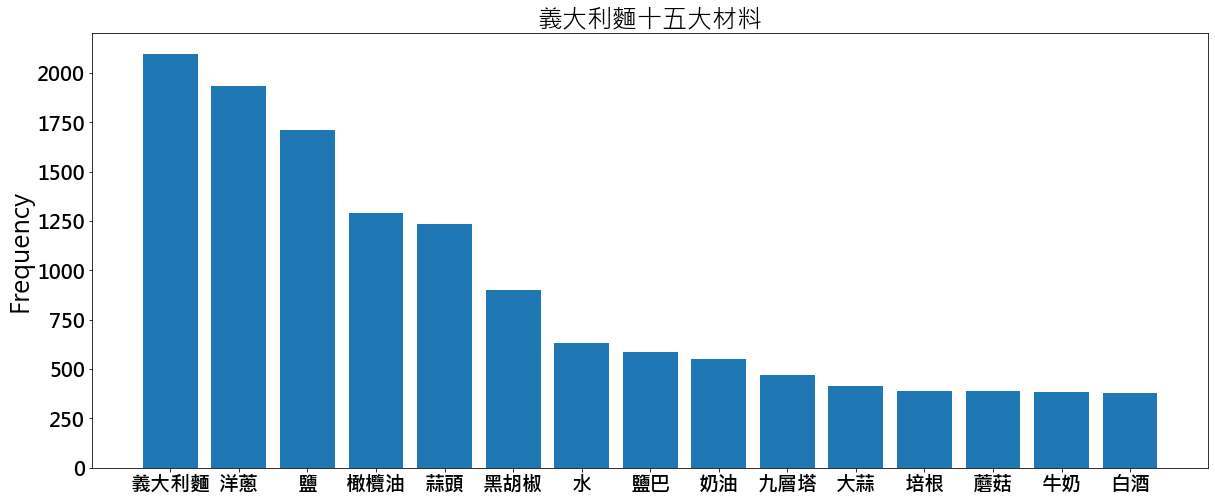

In [10]:
font = {'family' : 'Microsoft JhengHei',
'weight' : 'bold',
'size'  : '20'}
plt.rc('font', **font) 

fig, ax = plt.subplots(figsize = (20,8))
ax.bar(Material_Types.index[:15],
        Material_Types.values[:15])
ax.set_ylabel("Frequency", size = 25)
ax.set_title(f"{food}十五大材料", size = 25)
plt.savefig(f"{food}Material15.png", dpi = 300)

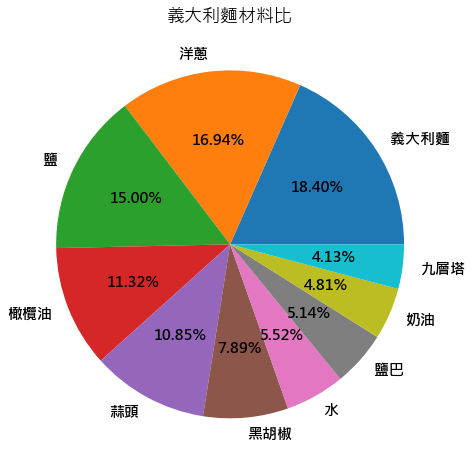

In [11]:
font = {'family' : 'Microsoft JhengHei',
'weight' : 'bold',
'size'  : '15'}
plt.rc('font', **font) 

fig, ax = plt.subplots(figsize = (20,8))
plt.pie(Material_Types[:10], labels=Material_Types.index[:10], autopct='%1.2f%%')
plt.title(f'{food}材料比')
plt.savefig(f"{food}Material_Pie.png", dpi = 300)
plt.show()